In [ ]:
from IPython.core.display import display
import IPython.display as ipd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
import torchvision
import urllib

# These settings are just for better visualization experience
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


print(f"Numpy: {np.__version__}\nTorch: {torch.__version__}\nTorchAudio: {torchaudio.__version__}\nTorchVision: {torchvision.__version__}")

# Load Model

In [13]:
model = torchvision.models.efficientnet_b2(pretrained=True)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 10, bias=True)
out_channels = int(model.features[0][0].extra_repr().split(',')[1].strip())
model.features[0][0] = torch.nn.Conv2d(1, out_channels, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
model.load_state_dict(torch.load('EffNetB2_550Epoch_CustomLR.pth', map_location=torch.device('cpu')))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"#params: {sum([p.numel() for p in model.parameters()]):,}")

# Test

### Prepare the Audio File

In [ ]:
audio_file_path = '210520_0671_30min_24bitPCM.wav' # path to our 30 minutes long audio file
raw_waveform, sr = torchaudio.load(audio_file_path) # load the audio file, it returns sampling rate as well
mel_transform = torchaudio.transforms.MelSpectrogram(n_fft=2048, hop_length=1024, n_mels=130)
target_sample_rate = 16000
# change the sample rate to be consistent with the data that model was trained on
resampler = torchaudio.transforms.Resample(sr, target_sample_rate) 
raw_waveform_resampled_at_16khz = resampler(raw_waveform)

### Helper Functions

In [ ]:
# numbers are based on the label numbers hat I gave them in training.
BIRD_NAMES = {0:"turdus merula",
              1:"phylloscopus collybita",
              2:"sylvia atricapilla",
              3:"columba palumbus",
              4:"fringilla coelebs", 
              5:"chloris chloris", 
              6:"troglodytes troglodytes", 
              7:"prunella modularis",
              8:"parus major", 
              9:"cyanistes caeruleus"}

In [ ]:
def get_10sec(position=0, duration=10, sr=16000):
    """
    This function returns non-overlapping segments of the audio file, starting the first one with position 0.
    The lenght of each segment is determined based on the duration argument. For example, position=5 and duration=10,
    will return a audio segment from 50 to 60 seconds of the audio file.
    
    args:
    -----
        position - position of the segment in the audio file, e.g., 0 for the first segment starting, 1 for second one, etc.
        sr - sampling rate of the audio file. the audio file contains samples based on this sampling rate.
        duration - duration of each segment in seconds.
    
    returns:
    --------
        segment - a segment of the audio clip, which its lenght and duration is determined by the input arguments.
    
    """
    start = position * duration * sr # each second contains "sr" samples
    end = (position + 1) * duration * sr
    audio_segment = raw_waveform_resampled_at_16khz[:, start:end] # first dimension is number of audio channels, which is 1 in our case
    return audio_segment

In [ ]:
def get_10sec_mel(audio_segment):
    """
    This function returns a mel-spectrogram from an audio segment. Log compression and standardization for each frequency component
    helps visualization. Also, the model was trained using this preprocessing on inputs. Hence, it should be done on test data as well.
    
    args:
    -----
        audio_segment - an audio segment in raw waveform format, should be 10 seconds.
        
    returns:
    --------
        mel - a normalized mel-spectrogram from the 10 seconds segment with the shape [1, 157, 130].
    """
    mel = mel_transform(audio_segment).transpose(-2, -1) # mel shape after transposing freq and time axis: [1, 157, 130] = [channel, time, freq]
    mel = torch.log(1 + mel * 10.)
    mu = mel.mean(dim=1, keepdim=True) # mu shape is [1, 1, 130], mean of each frequency across all time frames
    std = mel.std(dim=1, keepdim=True) + 1e-20 # std shape is [1, 1, 130], I added a small number to prevent potential division by zero error
    mel = (mel - mu) / std # normalizes each frequency bin separately
    return mel

In [ ]:
def analyze_recording(position=0):
    audio_segment = get_10sec(position=position, duration=10)
    mel = get_10sec_mel(audio_segment)
    mel = mel.unsqueeze(0).to(device)
    y = model(mel)
    y = np.argmax(y.cpu().detach().numpy())
    _ = plt.figure(figsize=(8,6))
    plt.title(f'predicted as {BIRD_NAMES[y]}')
    plt.imshow(mel.cpu().detach().numpy().squeeze().T, cmap=plt.cm.inferno, origin='lower')
    plt.ylabel("Mel Frequency")
    plt.xlabel("Time")
    plt.xticks(ticks=np.linspace(0, 157, 11, dtype=np.int32), labels=np.round(np.linspace(0, 10, 11, dtype=np.int32), 3), rotation=0)
    audio_segment = audio_segment.numpy().squeeze()
    display(ipd.Audio(audio_segment, rate=target_sample_rate))
    plt.colorbar(fraction=0.05, pad=0.05)
    plt.show()

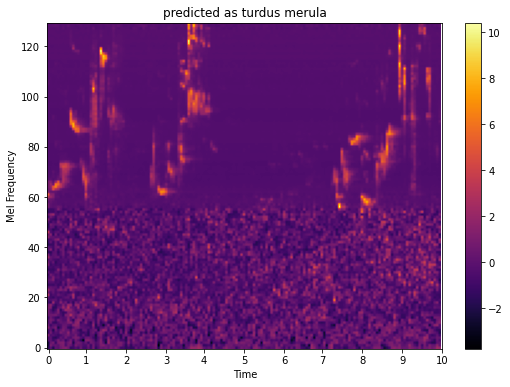

In [ ]:
# select positions from 0 to 179, there are 180 10-seconds in the 30 minutes recording
analyze_recording(position=21)

# Saving Predictions to a CSV File

In [ ]:
@torch.no_grad()
def get_csv_of_predictions(save_path='predicted_species.csv'):
    """
    Computes the predictions for each 10-seconds of the audio file, and returns a csv file of the results.
    
    returns:
    --------
        result - a csv file containing the predicted information.
    """
    df = pd.DataFrame(columns=['species', 'start time', 'end time'])
    
    for i in range(180): # there 180 10-seconds in 30 minutes recording file
        
        # these are for getting minutes and seconds of each 10 sec, ignore them
        #----------------------------------
        m, s = divmod(i*10, 60)
        m = f"{m}" if m//10!=0 else f"0{m}"
        s = f"{s}" if s//10!=0 else f"0{s}"
        start_time = m + ":" + s
        m, s = divmod((i+1)*10, 60)
        m = f"{m}" if m//10!=0 else f"0{m}"
        s = f"{s}" if s//10!=0 else f"0{s}"
        end_time = m + ":" + s
        #-----------------------------------
        
        # Predict the species
        audio_segment = get_10sec(position=i)
        mel = get_10sec_mel(audio_segment)
        mel = mel.unsqueeze(0) # append a batch dimension, so it is [1, 1, 157, 130] = [batch_size, channles, time, freq]
        mel = mel.to(device) # send data to the same device where the model resides in, gpu or cpu
        predictions = model(mel)
        species = np.argmax(predictions.cpu().numpy()) # select the maximum of 10 classes as the predicted label/species
        
        # append the result to the dataframe
        df = df.append({'species':BIRD_NAMES[species], 'start time':start_time, 'end time':end_time}, ignore_index=True)
    
    # save the dataframe as a csv file
    df.to_csv(save_path, index=False)
    return df

In [ ]:
csv = get_csv_of_predictions(save_path='predicted_species.csv')

In [ ]:
csv

,species,start time,end time
0,turdus merula,00:00,00:10
1,sylvia atricapilla,00:10,00:20
2,turdus merula,00:20,00:30
3,turdus merula,00:30,00:40
4,turdus merula,00:40,00:50
5,turdus merula,00:50,01:00
6,turdus merula,01:00,01:10
7,turdus merula,01:10,01:20
8,sylvia atricapilla,01:20,01:30
9,turdus merula,01:30,01:40
